In [ ]:
from datasets import load_dataset,Dataset,load_from_disk,Image
from collections import defaultdict
import random
import os
import tqdm
import torch
from sae_lens.activation_visualization import load_llava_model,load_sae,generate_with_saev
os.environ['HF_HOME'] ="/mnt/file2/changye/tmp/"
os.environ['TMPDIR'] ="/mnt/file2/changye/tmp/"
os.environ['HF_DATASETS_CACHE'] ="/mnt/file2/changye/tmp/"
os.environ['https_proxy'] = "127.0.0.1:7895"



In [ ]:
# please replace these path to your own path
MODEL_NAME = "llava-hf/llava-v1.6-mistral-7b-hf"
model_path = "/mnt/file2/changye/model/llava"
device = "cuda:0"
sae_device = "cuda:7"
sae_path = "/mnt/file2/changye/model/SAE/llavasae_obliec100k_SAEV"
dataset_path = "/mnt/file2/changye/dataset/semantic_data/imagenet1k_10"
columns_to_read = ["input_ids", "pixel_values", "attention_mask", "image_sizes"]

save_path = "../activation_visualization"


(
        processor,
        hook_language_model,
) = load_llava_model(MODEL_NAME, model_path, device,n_devices=8)

sae = load_sae(sae_path, sae_device)





In [3]:
example_prompt = """You are provided with an image and a list of 10 possible labels. Your task is to classify the image by selecting the most appropriate label from the list below:

Labels:
0: "bonnet, poke bonnet"
1: "green mamba"
2: "langur"
3: "Doberman, Doberman pinscher"
4: "gyromitra"
5: "Saluki, gazelle hound"
6: "vacuum, vacuum cleaner"
7: "window screen"
8: "cocktail shaker"
9: "garden spider, Aranea diademata"

Carefully analyze the content of the image and identify which label best describes it. Then, output only the **corresponding number** from the list without any additional text or explanation.
"""
# 加载本地 JSON 数据
local_dataset = load_from_disk(dataset_path)



In [ ]:
print(local_dataset['label'])
print(local_dataset['image'][0])

In [ ]:
from PIL import Image
system_prompt= " "
user_prompt= 'USER: \n<image> {input}'
assistant_prompt= '\nASSISTANT: {output}'
def prepare_inputs(prompt,image,processor):
    image = image.resize((336, 336)).convert('RGBA')
    formatted_prompt = f'{system_prompt}{user_prompt.format(input=prompt)}{assistant_prompt.format(output="")}'
    text_input = processor.tokenizer(formatted_prompt, return_tensors="pt")
    image_input = processor.image_processor(images=image, return_tensors="pt")
    # print(inputs)
    """处理样本并准备输入"""
    return {
        "input_ids": text_input["input_ids"],
        "attention_mask": text_input["attention_mask"],
        "pixel_values": image_input["pixel_values"],
        "image_sizes": image_input["image_sizes"],
    }

input_list= []
image_path="/mnt/file2/changye/SAELens-V-result/result/semantic_image/mustimi.png"
image=Image.open(image_path)
inputs=prepare_inputs(example_prompt,image,processor)

# for data in tqdm.tqdm(local_dataset['image']):
    
#     inputs = prepare_inputs(example_prompt, data,processor )
#     input_list.append(inputs)
print(inputs["input_ids"].shape)

In [ ]:
# 定义文件路径
cosi_file_path = "/mnt/file2/changye/dataset/interp/Align-Anything-interp/Align-Anything_cosi_weight/cosi_feature_list.txt"  # 将此替换为你的文件路径

# 读取文件并转换为字典
osi_list = []
with open(cosi_file_path, "r") as file:
    for line in file:
        key, value = line.strip().split(",")  # 按逗号分割每行
        
        osi_list.append((int(key), float(value)))

# 输出结果
print(osi_list)

In [ ]:

output_list = []
image_list = []
with tqdm.tqdm(total=len(input_list)) as pbar:
    for inputs,data in zip(input_list,local_dataset):
        inputs={
            "input_ids": inputs["input_ids"].to(device),
            "attention_mask": inputs["attention_mask"].to(device),
            "pixel_values": inputs["pixel_values"].to(device),
            "image_sizes": inputs["image_sizes"].to(device),
        }
        total_activation_l0_norms_list,patch_features_list,feature_act_list,image_indice,output=generate_with_saev(
                inputs, hook_language_model, processor, save_path, data["image"], sae, sae_device,max_new_tokens=1,selected_feature_indices=osi_list,
            )
        # print( total_activation_l1_norms_list[0].shape)
        output_list.append(output[-1])
        image_list.append({"image":data["image"].resize((336, 336)),"label":data["label"],"activation_l0":total_activation_l0_norms_list[0]})
        pbar.update(1)

   

In [ ]:
print(image_list[0].keys())

In [ ]:
from datasets import Dataset, Features, Array3D, Array2D,ClassLabel, Value
import numpy as np
import datasets
raw_data = []
for idx, entry in enumerate(image_list):
    # 转为 numpy 数组
    img_array = np.array(entry['image'])
    label = entry['label']
    activation = np.array(entry['activation_l0'], dtype=np.float32)

    # 检查image的维度和类型，期望 (336, 336, 3)
    if img_array.ndim == 2:
    # 若是灰度图，扩展成3通道
        if img_array.shape == (336, 336):
            img_array = np.stack([img_array]*3, axis=-1)
        else:
            raise ValueError(f"Image at index {idx} has unexpected shape {img_array.shape}")
    elif img_array.shape == (336, 336, 4):
        # 如果图像是 RGBA 格式，裁剪掉 alpha 通道，变成 RGB
        img_array = img_array[..., :3]

    # 再次检查image形状
    if img_array.shape != (336, 336, 3):
        raise ValueError(f"Image at index {idx} has shape {img_array.shape}, expected (336, 336, 3)")
    if img_array.dtype != np.uint8:
        # 若不是uint8，则尝试转换
        img_array = img_array.astype(np.uint8)

    # 检查activation的维度和类型，期望(24, 24)
    if activation.ndim == 1:
        # 若是(24*24,)的1D数组，重塑为(24,24)
        if activation.size == 24*24:
            activation = activation.reshape((24, 24))
        else:
            raise ValueError(f"Activation at index {idx} has size {activation.size}, cannot reshape to (24,24)")
    elif activation.shape != (24, 24):
        raise ValueError(f"Activation at index {idx} has shape {activation.shape}, expected (24,24)")

    # 确保类型为float32
    if activation.dtype != np.float32:
        activation = activation.astype(np.float32)

    raw_data.append({"image": img_array, "label": label, "activation_l0": activation})

# 转换为字典格式
raw_data_dict = {
    "image": [entry["image"] for entry in raw_data],
    "label": [entry["label"] for entry in raw_data],
    "activation_cosi": [entry['activation_l0'] for entry in raw_data]  # 可以直接是numpy数组
}

# 构建 ClassLabel 的 names 列表
label_names = sorted(list(set(raw_data_dict["label"])))  # 排序以保证稳定性

# 定义数据特征
features = Features({
    "image": datasets.Image(),    # 图像的维度和类型
    "label": ClassLabel(names=label_names),                  # 标签分类
    "activation_cosi": Array2D(dtype="float32", shape=(24, 24))   # 激活值的维度和类型
})

# 创建 Hugging Face 数据集
raw_hf_dataset = Dataset.from_dict(raw_data_dict, features=features)

# 验证数据集结构
print(raw_hf_dataset)

raw_hf_dataset.save_to_disk("imagenet10_activated_cosi_dataset")

In [ ]:
total=1000
acc=0
for i,output in enumerate(output_list):
    if output == str(local_dataset[i]['label']):
        acc+=1
print(acc)
print(f"accuracy:{acc/total}")

In [ ]:
# print(type(output_list[0]))
# print(local_dataset[0]['label'])
# print(len(image_list))
print(image_list[0]['activation'].shape)

In [12]:

import numpy as np
from PIL import Image
from IPython.display import display
import datasets
from datasets import Dataset, Features, Array3D, ClassLabel
import numpy as np

# # torch.save(image_list, 'image_l0_list.pt')
# image_list=torch.load("/mnt/file2/changye/dataset/image_list.pt")
    # display(final_image)


In [ ]:
#我现在有一张336*336的图片，和一个576大小的激活map，这个map按顺序地对应到图片上的每个patch(14X14),我希望能够按照激活值筛patch，例如将激活值后50%的patch改变为黑色，生成一张新的图片，请补全以下代码
threshold_percentile = 25  # 激活值的百分位数阈值
mask_image_list = []

for item in image_list:
    img = item['image']
    activation_mask = item['activation_l0']
    
    # 将PIL Image转换为numpy数组
    if isinstance(img, Image.Image):
        img = np.array(img)
    
    # 如果图像是灰度图（2D），转为三通道
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)  # 转为RGB格式
    
    # 对于576大小的激活mask，对应24x24个patch
    patch_count = 24
    patch_size = 336 // patch_count
    activation_mask = np.array(activation_mask).reshape(patch_count, patch_count)
    
    # 使用np.percentile计算指定百分位数作为阈值
    threshold = np.percentile(activation_mask, threshold_percentile)
    
    # 遍历每个patch并根据激活值进行操作
    for i in range(patch_count):
        for j in range(patch_count):
            if activation_mask[i, j] <= threshold:
                # 将对应patch区域设为黑色
                img[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = 0

    # 将修改后的图像加入列表
    mask_image_list.append({"image":Image.fromarray(img),"label":item['label']})
    

# 假设 mask_image_list 已经按照你提供的格式存在
# mask_image_list.append({"image": Image.fromarray(img), "label": item['label']})

# 将 PIL 图片转换为 numpy 数组，并格式化数据
data = []
for entry in mask_image_list:
    img_array = np.array(entry['image'])  # 转换为 numpy 数组
    label = entry['label']               # 获取标签
    data.append({"image": img_array, "label": label})

# 转换为字典格式
data_dict = {
    "image": [entry["image"] for entry in data],
    "label": [entry["label"] for entry in data]
}

# 定义数据特征（包括 image 和 label）
features = Features({
    "image": datasets.Image(),  # 图像的维度和类型
    "label": ClassLabel(names=list(set(data_dict["label"])))  # 标签分类
})

# 创建 Hugging Face 数据集
hf_dataset = Dataset.from_dict(data_dict, features=features)

# 验证数据集结构
print(hf_dataset)
hf_dataset.save_to_disk(f"imagenet10_cosi_mask{100-threshold_percentile}_dataset")


In [ ]:
display(mask_image_list[0]['image'])

In [ ]:
from PIL import Image
import numpy as np
from datasets import load_from_disk, Dataset, Features, ClassLabel as DsImage
import datasets
data = load_from_disk("/mnt/file2/changye/dataset/imagenet1k_10")

def sample_patches(example, keep_ratio):
    """对图像进行14x14的patch分割并随机保留一定比例的patch，其余用0填充。"""
    image = example["image"]
    if not isinstance(image, Image.Image):
        image = Image.fromarray(np.uint8(image))
    image = image.resize((336,336)).convert('RGB')  # 确保为RGB三通道

    image = np.array(image)  # (H, W, C)
    h, w, c = image.shape
    patch_size = 14
    # 假设图像尺寸可以被14整除，如不能，则需预处理
    num_patches_h = h // patch_size
    num_patches_w = w // patch_size
    total_patches = num_patches_h * num_patches_w

    keep_count = int(total_patches * keep_ratio)
    keep_indices = set(np.random.choice(total_patches, keep_count, replace=False))

    new_image = image.copy()
    patch_index = 0
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            if patch_index not in keep_indices:
                # 将该patch区域填充为黑色
                new_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = 0
            patch_index += 1
    
    # 转回PIL Image
    new_image = Image.fromarray(new_image.astype(np.uint8))
    return new_image

keep_ratio = 0.75  # 例如：保留25%的patch，从而丢弃75%
new_images = []
new_labels = []  # 假设原数据集有 'label' 字段，如有其它字段也同样处理

for i in range(len(data)):
    example = data[i]
    transformed_image = sample_patches(example, keep_ratio=keep_ratio)
    # 转成numpy array，以便后续使用Image特征类型
    transformed_array = np.array(transformed_image)
    new_images.append(transformed_array)
    # 假设有 'label' 字段，如果没有可去掉
    new_labels.append(example["label"])

# 构建新的数据集
# 假设原数据集有一个label字段且为ClassLabel类型，否则根据实际情况调整
features = Features({
    "image": datasets.Image(),
    "label": data.features["label"]  # 如果label是ClassLabel之类的特征，则直接引用即可
})

new_dataset = Dataset.from_dict({"image": new_images, "label": new_labels}, features=features)

# 保存新数据集
new_dataset.save_to_disk("/mnt/file2/changye/dataset/imagenet10_random_mask75_dataset")


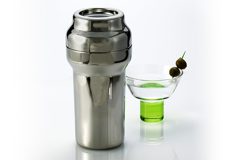

In [77]:
#119 206 633 841
from PIL import Image
import numpy as np
from datasets import load_from_disk, Dataset, Features, ClassLabel as DsImage
import datasets
# data = load_from_disk("/mnt/file2/changye/dataset/semantic_data/imagenet10_cosi_mask75_dataset")
data=load_from_disk("/mnt/file2/changye/dataset/semantic_data/imagenet1k_10")
display(data[841]["image"])